In [1]:
%matplotlib inline 
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [3]:
import os

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from scipy.stats import spearmanr

In [4]:
from access_biology_data import meta, relations, annotation, properties
from access_literature_data import medline
from access_science_shared import standardizer

import sys
sys.path.append('./../src/')
from aging_tools import inout, export, calculators
from access_aging_data import chaperome, earlier_studies, sequencing


In [5]:
import random

In [6]:
import matplotlib
matplotlib.rcParams.update({'font.size': 10})

In [7]:
out_folder = '211124_rank_based_feature_illustration'
in_folder = '190406_predict_fold_change_mouse'

In [8]:
save_images = False
# save_late_images = True

In [9]:
from narrative import nar181026_heat_confidence_genes

In [10]:
ref_genes = standardizer.reference_genes(10090, 'orp')  # only consider supported protein coding-genes

/Users/tstoeger/opt/miniconda3/envs/aging/lib/python3.7/site-packages/fastparquet/dataframe.py:5: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import CategoricalIndex, RangeIndex, Index, MultiIndex


In [11]:
all_de, detection, mice_in_comparisons, triplicate_series = nar181026_heat_confidence_genes.load_detection(
    detection_column='padj')

tissues_to_consider = ['BAT', 'Blood', 'GutEP', 'MuscSat', 'Adrenal', 'Kidney',
       'Heart', 'Liver', 'Skin', 'Stomach', 'Brain', 'SI',
       'LI', 'Cerebellum', 'WAT', 'Esophagus', 'Lung'] 
pfus=[0]

In [12]:
all_de = all_de[
    (all_de['younger'] == 4) & 
    (all_de['is_detected'] == True) &
    (all_de['de_unit'] == 'both') &
    (all_de['tissue'].isin(tissues_to_consider)) &
    (all_de['pfu'].isin(pfus)) & 
    (all_de['gene_ncbi'].isin(ref_genes))
]
all_de['significant'] = all_de['padj'] < 0.05

In [13]:
sign = all_de[['condition', 'significant']].groupby('condition').agg(sum)

In [14]:
agg = []

for condition in all_de['condition'].unique():

    p = export.get_material_path(
        '{}/predictions_{}.csv'.format(in_folder, condition))
    if os.path.exists(p):
        agg.append(pd.read_csv(p))


df = pd.concat(agg).rename(columns={'Unnamed: 0': 'condition'}).set_index('condition')
df['mean'] = df.mean(1)
d = pd.merge(sign.reset_index(), df[['mean']].reset_index())
f = d['significant'] > 0
d.loc[f, 'log_significant'] = d.loc[f, 'significant'].apply(lambda x: np.log10(x))

In [15]:
zeros = sum(~f)

In [39]:
f.sum()

68

In [42]:
np.sum(~f)

0

In [16]:
h = []
for j in range(zeros):
    h.append(-1 + random.randrange(0, 10)/20)
d.loc[~f, 'log_significant'] = h

In [17]:
f = d['condition'].str.contains('_0_4_[0-9]*$')
d = d[f]

In [18]:
d = pd.merge(d, all_de[['condition', 'younger', 'older']].drop_duplicates())

In [19]:
agg = []

for condition in all_de['condition'].unique():

    p = export.get_material_path(
        '{}/features_{}.csv'.format(in_folder, condition))

    if os.path.exists(p):
        h = pd.read_csv(p).set_index('feature')
        h = h.mean(1).to_frame('contribution').rename_axis('feature').reset_index()
        h.loc[:, 'condition'] = condition
        agg.append(h)



u = pd.concat(agg)

In [20]:
pi = u.pivot(index='condition', columns='feature', values='contribution')

In [21]:
(pi.rank(axis='columns', ascending=False)<=10).sum().sort_values().tail(20)

feature
tf_Rela              6
tf_Esr1              6
tf_Pou5f1            8
tf_Nr1d1             8
tf_Pparg             8
tf_Ppara            10
gene_CG             14
tf_Med1             15
miRNA_total         17
tf_Kmt2b            18
tf_Brd4             20
gene_C              28
rna_cds_SumACGT     46
gene_G              46
gene_A              47
gene_T              49
rna_full_CG         52
gene_SumACGT        60
rna_full_SumACGT    61
tf_different_tfs    68
dtype: int64

In [22]:
ranks = pi.rank(axis='columns', ascending=False)

In [23]:
(ranks['tf_different_tfs']==1).sum()

17

In [24]:
ranks.loc['Heart_0_4_18', :].sort_values()

feature
tf_Brd4                 1.0
rna_cds_SumACGT         2.0
rna_full_SumACGT        3.0
tf_Rela                 4.0
rna_full_CG             5.0
                      ...  
miRNA_miR-488-3p     1508.0
miRNA_miR-487b-3p    1508.0
miRNA_miR-486b-5p    1508.0
miRNA_miR-5103       1508.0
miRNA_miR-6516-3p    1508.0
Name: Heart_0_4_18, Length: 2236, dtype: float64

In [25]:
ranks.loc[:, [x for x in ranks.columns if x.startswith('tf')]].drop(columns=['tf_different_tfs']).median(0).sort_values()

feature
tf_Kmt2b       22.00
tf_Brd4        25.00
tf_Pparg       28.00
tf_Esr1        35.00
tf_Nr3c1       35.50
              ...   
tf_Elk3      1446.25
tf_Eomes     1446.25
tf_Hnf4g     1446.25
tf_Znf431    1446.25
tf_Hsf2      1446.25
Length: 309, dtype: float64

In [26]:
u = ranks.loc[:, [x for x in ranks.columns if x.startswith('tf')]].drop(columns=['tf_different_tfs'])

In [27]:
(u<10).sum().sort_values().tail(20)

feature
tf_Tbp        2
tf_Elf5       3
tf_Ar         3
tf_Ets1       3
tf_Runx2      3
tf_Rora       3
tf_Spi1       4
tf_Mef2d      4
tf_Foxa1      4
tf_Nkx3-1     4
tf_Nr1d2      5
tf_Esr1       5
tf_Rela       6
tf_Nr1d1      6
tf_Pou5f1     7
tf_Pparg      7
tf_Ppara     10
tf_Kmt2b     14
tf_Med1      15
tf_Brd4      19
dtype: int64

In [28]:
# ranks.loc[:, [x for x in ranks.columns if x.startswith('tf')]].drop(columns=['tf_different_tfs']).min(1).to_frame('best_tf')

In [29]:
# ranks.loc[:, [x for x in ranks.columns if x.startswith('miRNA')]].drop(columns=['miRNA_total']).min(1).to_frame('best_mirna')

In [30]:
# ranks[['rna_full_SumACGT', 'rna_cds_SumACGT', 'gene_SumACGT']].min(1).to_frame('best_length')

In [31]:
toy = pd.concat(
    [
        ranks.loc[:, [x for x in ranks.columns if x.startswith('tf')]].drop(columns=['tf_different_tfs']).min(1).to_frame('best_tf'),
        ranks.loc[:, [x for x in ranks.columns if x.startswith('miRNA')]].drop(columns=['miRNA_total']).min(1).to_frame('best_mirna'),
        ranks[['rna_full_SumACGT', 'rna_cds_SumACGT', 'gene_SumACGT']].min(1).to_frame('best_length'),
        ranks[['rna_full_SumACGT', 'rna_cds_SumACGT', 'gene_SumACGT', 'tf_different_tfs', 'miRNA_total']]
    ],
    axis=1


)

In [32]:
toy.stack().to_frame('rank').rename_axis(['condition', 'categ']).reset_index().groupby(
    ['categ'])['rank'].median().sort_values()

categ
best_length          1.0
rna_full_SumACGT     2.5
tf_different_tfs     3.0
best_tf              4.0
gene_SumACGT         4.0
rna_cds_SumACGT      5.0
miRNA_total         15.0
best_mirna          22.0
Name: rank, dtype: float64

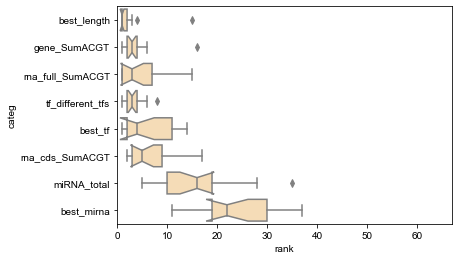

In [33]:
sns.boxplot(
    y='categ',
    x='rank',
    data=toy[toy.index.str.contains('_4_9')].stack().to_frame('rank').rename_axis(['condition', 'categ']).reset_index(),
    notch=True,
    order=toy[toy.index.str.contains('_4_9')].stack().to_frame('rank').rename_axis(['condition', 'categ']).reset_index().groupby(
        ['categ'])['rank'].median().sort_values().index,
    color='navajowhite'


)

plt.xlim(0, toy.max().max()+2)



if save_images:
    export.export_image(
        '{}/9_months.pdf'.format(out_folder))

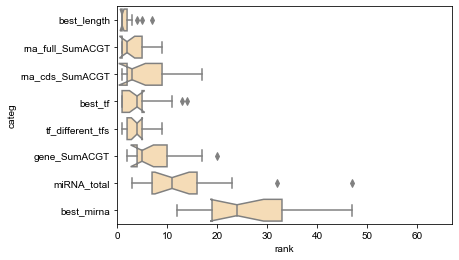

In [34]:
sns.boxplot(
    y='categ',
    x='rank',
    data=toy[toy.index.str.contains('_4_24')].stack().to_frame('rank').rename_axis(['condition', 'categ']).reset_index(),
    notch=True,
    order=toy[toy.index.str.contains('_4_24')].stack().to_frame('rank').rename_axis(['condition', 'categ']).reset_index().groupby(
        ['categ'])['rank'].median().sort_values().index,
    color='navajowhite'
)



plt.xlim(0, toy.max().max()+2)



if save_images:
    export.export_image(
        '{}/24_months.pdf'.format(out_folder))

In [35]:
save_images

False

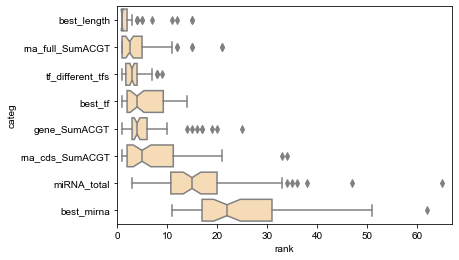

In [36]:
sns.boxplot(
    y='categ',
    x='rank',
    data=toy.stack().to_frame('rank').rename_axis(['condition', 'categ']).reset_index(),
    notch=True,
    order=toy.stack().to_frame('rank').rename_axis(['condition', 'categ']).reset_index().groupby(
        ['categ'])['rank'].median().sort_values().index,
    color='navajowhite'


)

plt.xlim(0, toy.max().max()+2)


if save_images:
    export.export_image(
        '{}/all.pdf'.format(out_folder))

In [37]:

toy

,best_tf,best_mirna,best_length,rna_full_SumACGT,rna_cds_SumACGT,gene_SumACGT,tf_different_tfs,miRNA_total
condition,,,,,,,,
Adrenal_0_4_12,2.0,43.0,12.0,12.0,21.0,19.0,1.0,36.0
Adrenal_0_4_18,2.0,36.0,4.0,11.0,21.0,4.0,1.0,20.0
Adrenal_0_4_24,1.0,37.0,5.0,5.0,9.0,14.0,4.0,47.0
Adrenal_0_4_9,2.0,36.0,3.0,9.0,17.0,3.0,1.0,22.0
BAT_0_4_12,2.0,40.0,5.0,21.0,34.0,5.0,1.0,38.0
...,...,...,...,...,...,...,...,...
Stomach_0_4_9,4.0,30.0,1.0,1.0,5.0,3.0,2.0,19.0
WAT_0_4_12,1.0,62.0,15.0,15.0,33.0,25.0,2.0,65.0
WAT_0_4_18,1.0,51.0,11.0,21.0,11.0,17.0,4.0,33.0
